# Model Comparison

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from   tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from   matplotlib.ticker import FuncFormatter

In [2]:
tqdm.pandas()

In [3]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from DataPreprocess import InflationPCA

## Raw Signal Comparison

In this case start by generating the signal per each PC and each inputted value and then take the correlation of each PC per each inputted group.

In [4]:
def get_signal_correlation() -> pd.DataFrame: 
    
    df_corr = (InflationPCA().pca_signal().drop(
        columns = ["inflation", "breakeven", "lag_spread"]).
        pivot(index = ["date", "variable"], columns = "input_val", values = "spread").
        reset_index().
        drop(columns = ["date"]).
        groupby("variable").
        agg("corr").
        reset_index().
        query("log_value != 1").
        drop(columns = ["raw_value"]).
        rename(columns = {"log_value": "correlation"}).
        drop(columns = ["input_val"]))
    
    return df_corr

df_corr = get_signal_correlation()

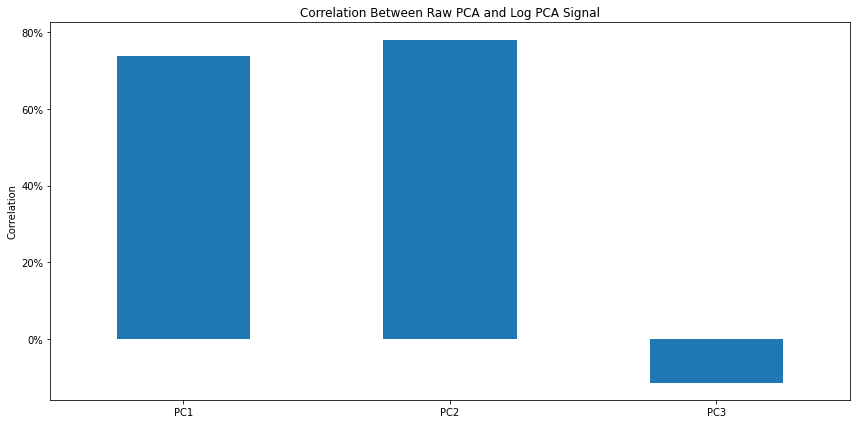

In [5]:
def plot_signal_corr(df_corr: pd.DataFrame) -> plt.Figure: 
    
    fig, ax = plt.subplots(figsize = (12,6))

    (df_corr.set_index(
        "variable").
        plot(
            kind   = "bar",
            legend = False,
            rot    = 0,
            xlabel = "",
            ylabel = "Correlation",
            title  = "Correlation Between Raw PCA and Log PCA Signal",
            ax     = ax))

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    plt.tight_layout()
    
plot_signal_corr(df_corr)

Now apply the signal to each security and then take the correlation of the performance for each PC between each signal.

In [6]:
def get_signal_performance() -> pd.DataFrame: 
    
    df_tsy = (InflationPCA().get_tsy_fut().assign(
        security = lambda x: x.security.str.split(" ").str[0])
        [["date", "security", "PX_bps"]])

    df_combined = (InflationPCA().pca_signal()[
        ["date", "input_val", "variable", "lag_spread"]].
        merge(right = df_tsy, how = "inner", on = ["date"]).
        assign(
            signal_bps = lambda x: -np.sign(x.lag_spread) * x.PX_bps,
            input_val  = lambda x: np.where(x.input_val == "log_value", "Log", "Raw")))
    
    return df_combined

df_signal_perf = get_signal_performance()

In [7]:
def get_signal_perfomance_corr(df_signal_perf: pd.DataFrame) -> pd.DataFrame: 
    
    df_corr = (df_signal_perf[
        ["date", "input_val", "variable", "security", "signal_bps"]].
        pivot(index = ["date", "variable", "security"], columns = "input_val", values = "signal_bps").
        reset_index().
        drop(columns = ["date"]).
        groupby(["variable", "security"]).
        agg("corr").
        drop(columns = ["Raw"]).
        query("Log != 1").
        rename(columns = {"Log": "correlation"}).
        reset_index().
        drop(columns = ["input_val"]))
    
    return df_corr

df_signal_perf_corr = get_signal_perfomance_corr(df_signal_perf)

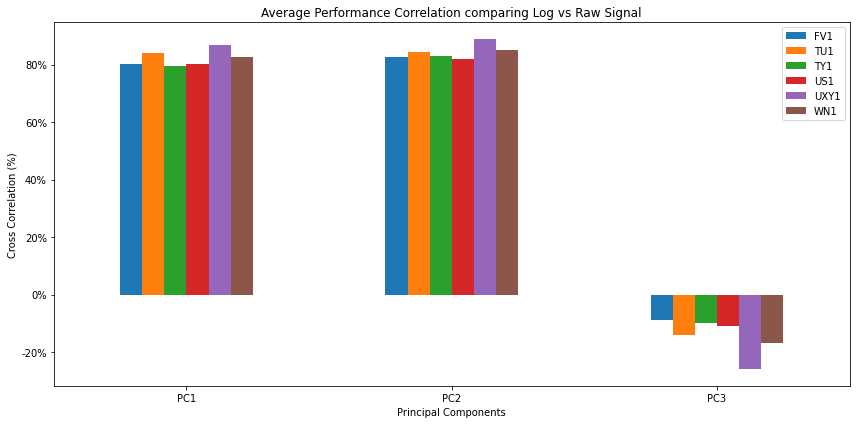

In [8]:
def plot_signal_perf_corr(df_signal_perf_corr: pd.DataFrame) -> plt.Figure: 
    
    fig, ax = plt.subplots(figsize = (12,6))

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    (df_signal_perf_corr.rename(
        columns = {"security": ""}).
        pivot(index = "variable", columns = "", values = "correlation").
        plot(
            kind   = "bar",
            xlabel = "Principal Components",
            rot    = 0,
            ylabel = "Cross Correlation (%)",
            ax     = ax,
            title  = "Average Performance Correlation comparing Log vs Raw Signal"))
    
    plt.tight_layout()
    
plot_signal_perf_corr(df_signal_perf_corr)

## Signal Performance Comparison

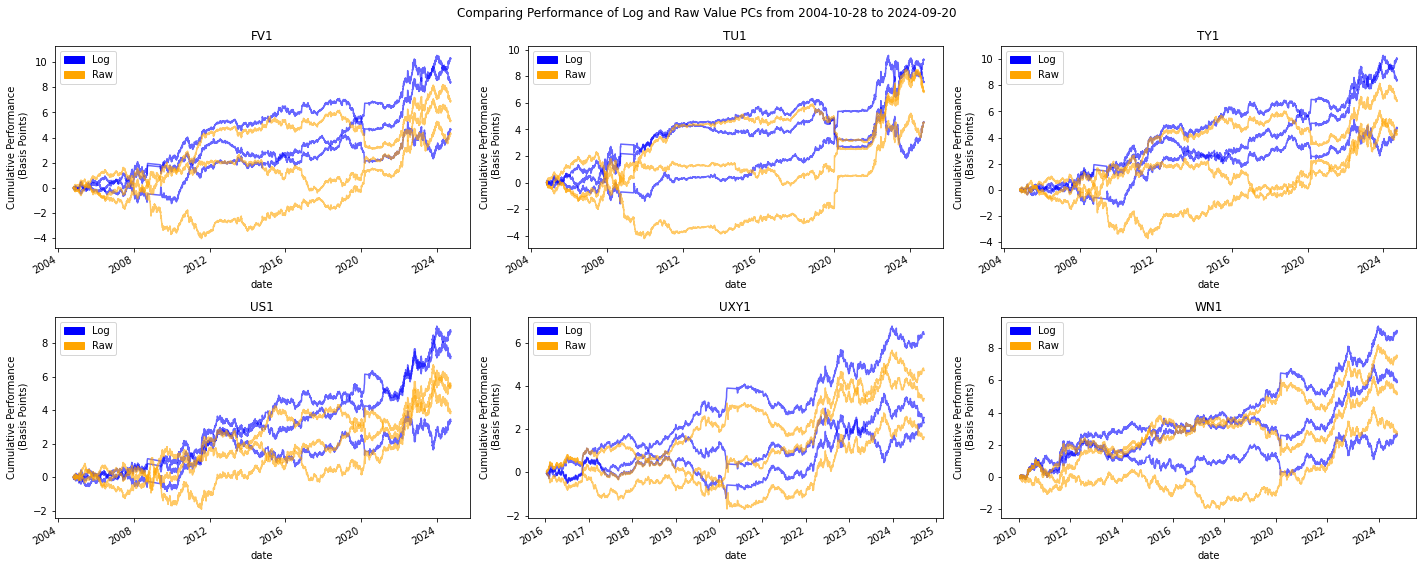

In [9]:
def plot_signal_perf_comparison(df_signal_perf: pd.DataFrame) -> plt.Figure: 
    
    securities = df_signal_perf.security.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(securities) // 2, nrows = len(securities) // 3, figsize = (20,8))

    for security, ax in zip(securities, axes.flatten()): 

        df_tmp = (df_signal_perf.query(
            "security == @security")
            [["date", "input_val", "variable", "signal_bps"]])

        input_vals = {
            "Log": "Blue",
            "Raw": "Orange"}

        for input_val in input_vals.keys(): 

            (df_tmp.query(
                "input_val == @input_val").
                drop(columns = ["input_val"]).
                pivot(index = "date", columns = "variable", values = "signal_bps").
                cumsum().
                plot(
                    ax     = ax,
                    legend = False,
                    color  = input_vals[input_val],
                    alpha  = 0.6,
                    title  = security,
                    ylabel = "Cumulative Performance\n (Basis Points)"))

            handles = [
                mpatches.Patch(color=color, label=label) 
                for label, color in input_vals.items()]

            ax.legend(handles = handles)

    fig.suptitle("Comparing Performance of Log and Raw Value PCs from {} to {}".format(
        df_signal_perf.date.min().date(),
        df_signal_perf.date.max().date()))

    plt.tight_layout()
    
plot_signal_perf_comparison(df_signal_perf)

Now compare the sharpe of each signal of each security. 

In [10]:
def get_sharpe_spread(df_signal_perf: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe_spread = (df_signal_perf.drop(
        columns = ["lag_spread", "PX_bps", "date"]).
        groupby(["input_val", "variable", "security"]).
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["input_val", "variable", "security", "sharpe"]].
        pivot(index = ["variable", "security"], columns = "input_val", values = "sharpe").
        assign(sharpe_spread = lambda x: x.Log - x.Raw).
        reset_index())
    
    return df_sharpe_spread

df_sharpe_spread = get_sharpe_spread(df_signal_perf)

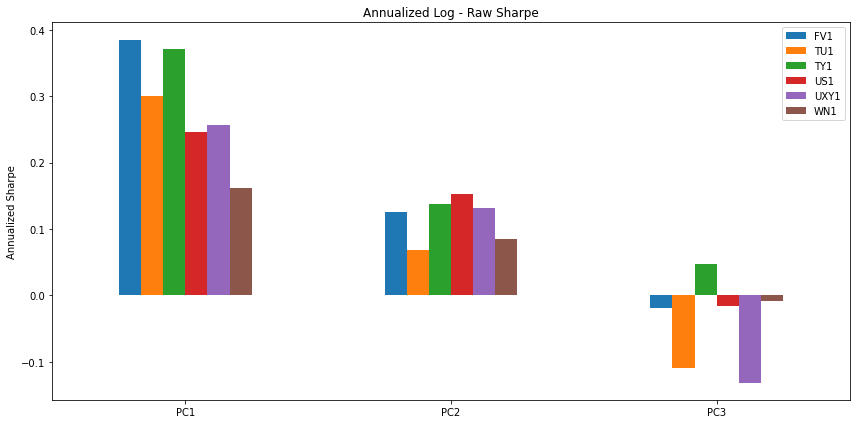

In [11]:
def plot_sharpe_spread(df_sharpe_spread: pd.DataFrame) -> plt.Figure: 
    
    (df_sharpe_spread[
        ["variable", "security", "sharpe_spread"]].
        rename(columns = {"security": ""}).
        pivot(index = "variable", columns = "", values = "sharpe_spread").
        plot(
            kind    = "bar",
            ylabel  = "Annualized Sharpe",
            xlabel  = "",
            rot     = 0,
            figsize = (12,6),
            title   = "Annualized Log - Raw Sharpe"))
    
    plt.tight_layout()
    
plot_sharpe_spread(df_sharpe_spread)

From this its evident that trading the log PCs is better, although for some securities in PC3 its not worth it (from a relative standpoint). But this is just a snapshot in time. To refine this idea start by taking the spread between rolling sharpes over a 30d period and then compare the distribution of the spread. 

In [12]:
def _get_rolling_sharpe(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.assign(
        mean_rtn    = lambda x: x.signal_bps.rolling(window = window).mean(),
        std_rtn     = lambda x: x.signal_bps.rolling(window = window).std(),
        roll_sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        dropna())
    
    return df_out

def get_rolling_sharpe(df_signal_perf: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_roll_sharpe = (df_signal_perf.assign(
        group_var = lambda x: x.input_val + " " + x.variable + " " + x.security).
        groupby("group_var").
        apply(_get_rolling_sharpe, window).
        reset_index(drop = True)
        [["date", "security", "input_val", "variable", "roll_sharpe"]].
        pivot(index = ["date", "security", "variable"], columns = "input_val", values = "roll_sharpe").
        assign(spread = lambda x: x.Log - x.Raw).
        reset_index())
    
    return df_roll_sharpe

df_roll_sharpe = get_rolling_sharpe(df_signal_perf)

Now take the mean of each rolling sharpe spread

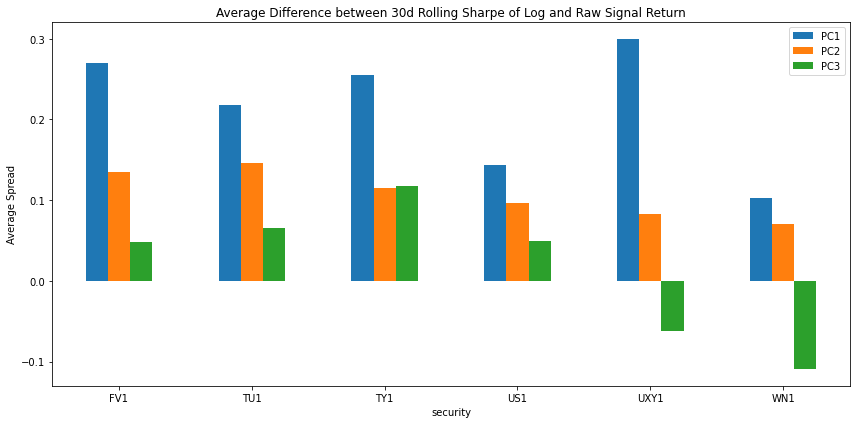

In [13]:
def plot_roll_sharpe_avg(df_roll_sharpe: pd.DataFrame) -> plt.Figure: 
    
    (df_roll_sharpe[
        ["security", "variable", "spread"]].
        groupby(["security", "variable"]).
        agg("mean").
        reset_index().
        rename(columns = {"variable": ""}).
        pivot(index = "security", columns = "", values = "spread").
        plot(
            kind    = "bar",
            rot     = 0,
            ylabel  = "Average Spread",
            title   = "Average Difference between 30d Rolling Sharpe of Log and Raw Signal Return",
            figsize = (12,6)))

    plt.tight_layout()
    
plot_roll_sharpe_avg(df_roll_sharpe)

This implies (without testing for significance) that over the time frame of all of the historical data using a monthly window there's likely not going to be a scenario in which the preference is to trade the raw PC over the log. 